<a href="https://colab.research.google.com/github/paulandrea0/Clasificaci-n_AutoEncoder_con_FFT/blob/main/FFT_Detectando_tipos_de_se%C3%B1ales_comp_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Set de datos** 

El set de datos corresponde a señales de sismos volcánicos del tipo VT, LP y Tor

**1.1 Lectura de datos desde Google Drive**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Set de entrenamiento y validación para seãnales sísmicas en el componente Z

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

#%reset
df_test_1 = pd.read_csv('/gdrive/MyDrive/Sismos/VT_N_teste.csv')
df_train_1 = pd.read_csv('/gdrive/MyDrive/Sismos/VT_N_train.csv') 
df_test_2 = pd.read_csv('/gdrive/MyDrive/Sismos/LP_N_teste.csv')
df_train_2 = pd.read_csv('/gdrive/MyDrive/Sismos/LP_N_train.csv')
df_test_3 = pd.read_csv('/gdrive/MyDrive/Sismos/TOR_N_teste.csv')
df_train_3 = pd.read_csv('/gdrive/MyDrive/Sismos/TOR_N_train.csv')


**1.2 Aplicando función Mean para quitar el OffSet de los datos**                                                                                                                                
Normalización a 3000 muestras por registro. 

(1472, 13348)
(256, 10993)
(362, 3000)
(40, 3000)
(61, 27408)
(6, 13528)


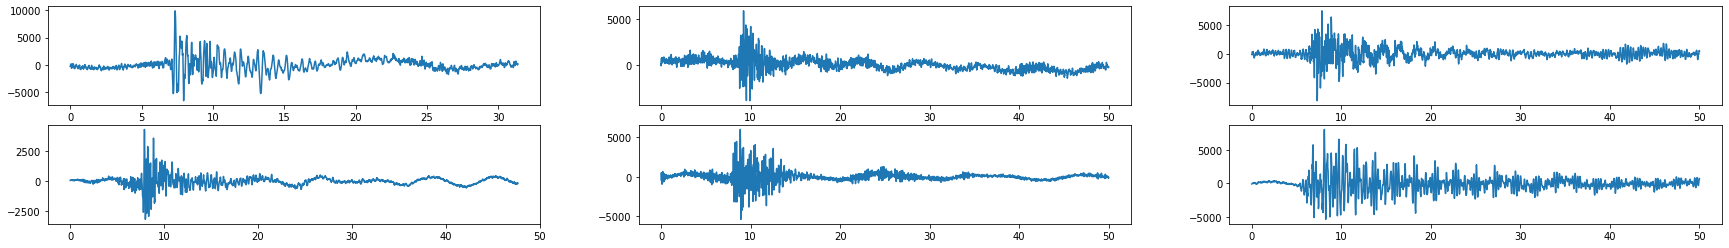

In [3]:
# Creando función para retirar el offset de los datos en DataFrame
def mean_norma(df_input):
        return df_input.apply(lambda x: (x-x.mean()), axis=1)  

df_mean_test_1 = mean_norma(df_test_1)  # Señales VT
df_mean_train_1 = mean_norma(df_train_1)
df_mean_test_2 = mean_norma(df_test_2)  # Señales LP
df_mean_train_2 = mean_norma(df_train_2)
df_mean_test_3 = mean_norma(df_test_3)  # Señales Tor
df_mean_train_3 = mean_norma(df_train_3)

print(df_mean_train_1.shape)
print(df_mean_test_1.shape)
print(df_mean_train_2.shape)
print(df_mean_test_2.shape)
print(df_mean_train_3.shape)
print(df_mean_test_3.shape)

# Convirtiendo el dataframe en array
d_train_1 = df_mean_train_1.values
d_train_1 = d_train_1[:, 0:3000]
d_test_1 = df_mean_test_1.values
d_test_1 = d_test_1[:, 0:3000]

d_train_2 = df_mean_train_2.values
d_train_2 = d_train_2[:, 0:3000]
d_test_2 = df_mean_test_2.values
d_test_2 = d_test_2[:, 0:6000]

d_train_3 = df_mean_train_3.values
d_train_3 = d_train_3[:, 0:3000]
d_test_3 = df_mean_test_3.values
d_test_3 = d_test_3[:, 0:3000]

# Dibujando la señal orioginal
n = 3000
fs = 50 # frecuencia de muestreo
t = np.linspace(0,fs,n)
plt.figure(1, figsize=(30, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233) 
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

**1.3 Eliminando valores NaN de los arreglos Numpy** 

(1472, 3000)
(256, 3000)
(362, 3000)
(40, 3000)
(61, 3000)
(6, 3000)


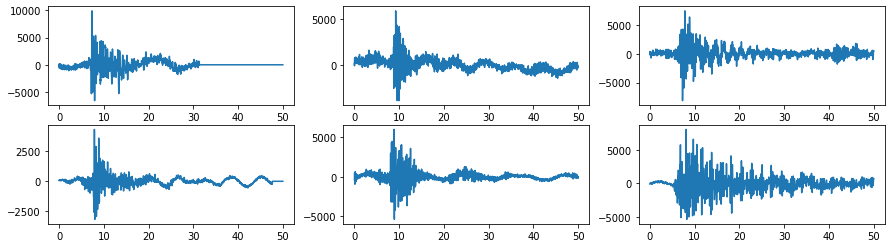

In [4]:
# Quitando los valores NaN de los array numpy

# Señales VT
d_train_1[np.isnan(d_train_1)] = 0.0
d_test_1[np.isnan(d_test_1)] = 0.0
print(d_train_1.shape)
print(d_test_1.shape)

# Señales LP
d_train_2[np.isnan(d_train_2)] = 0.0
d_test_2[np.isnan(d_test_2)] = 0.0
print(d_train_2.shape)
print(d_test_2.shape)

# Señales Tor`
d_train_3[np.isnan(d_train_3)] = 0.0
d_test_3[np.isnan(d_test_3)] = 0.0
print(d_train_3.shape)
print(d_test_3.shape)

# Graficando
plt.figure(2, figsize=(15, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233) 
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

**1.4 Aplicando transformada de Fourier al DataSet**

Al aplicar la transformada de Fourier a mis datos, estos pueden quedar reducidos a la mitad en cuanto a los elementos a ser presentados en la entrada del autoencoder, así mejorando el rendimiento. Además las carácterísticas a ser aprendidas por el modelo pueden resultar más claras.

1500
(1472, 1500) (256, 1500)
(362, 1500) (40, 1500)
(61, 1500) (6, 1500)


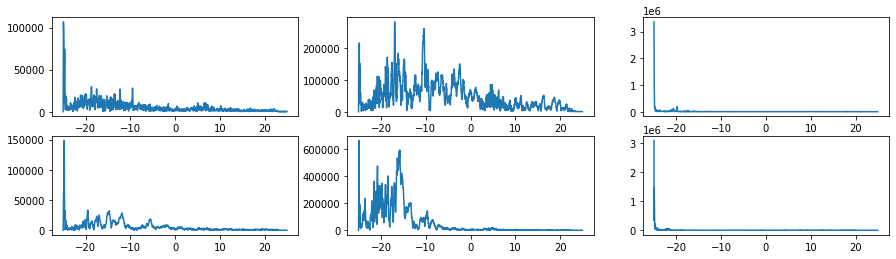

In [5]:
import scipy.fft as sfft

# Transformada de Fourier
n2 = 1500
t2 = np.linspace(0,fs,n2) # creando un vector de tiempo
print(len(t2))

f = sfft.fftshift(sfft.fftfreq(n=len(t2), d=1./fs))

# Señales VT
S_train_1 = sfft.fftshift(sfft.fft(d_train_1))
SA_train_1 = np.absolute(S_train_1)
SA_train_1 = SA_train_1[:, 1500:3000]

S_test_1 = sfft.fftshift(sfft.fft(d_test_1))
SA_test_1 = np.absolute(S_test_1)
SA_test_1 = SA_test_1[:, 1500:3000]

# Señales LP
S_train_2 = sfft.fftshift(sfft.fft(d_train_2))
SA_train_2 = np.absolute(S_train_2)
SA_train_2 = SA_train_2[:, 1500:3000]

S_test_2 = sfft.fftshift(sfft.fft(d_test_2))
SA_test_2 = np.absolute(S_test_2)
SA_test_2 = SA_test_2[:, 1500:3000]

# Señales Tor
S_train_3 = sfft.fftshift(sfft.fft(d_train_3))
SA_train_3 = np.absolute(S_train_3)
SA_train_3 = SA_train_3[:, 1500:3000]

S_test_3 = sfft.fftshift(sfft.fft(d_test_3))
SA_test_3 = np.absolute(S_test_3)
SA_test_3 = SA_test_3[:, 1500:3000]

print(SA_train_1.shape, SA_test_1.shape)
print(SA_train_2.shape, SA_test_2.shape)
print(SA_train_3.shape, SA_test_3.shape)

# Graficando
plt.figure(3, figsize=(15, 4))
plt.subplot(231)
plt.plot(f, SA_train_1[60])
plt.subplot(232)
plt.plot(f, SA_train_2[18])
plt.subplot(233) 
plt.plot(f, SA_train_3[38])
plt.subplot(234)
plt.plot(f, SA_test_1[44])
plt.subplot(235)
plt.plot(f, SA_test_2[34])
plt.subplot(236)
plt.plot(f, SA_test_3[4])

**1.5 Normalización**

Mínimo y máximo originales: 0.0, 162728980.2
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: 0.0, 12346454.8
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: 0.0, 7987369.5
Mínimo y máximo normalizado: 0.0, 1.0


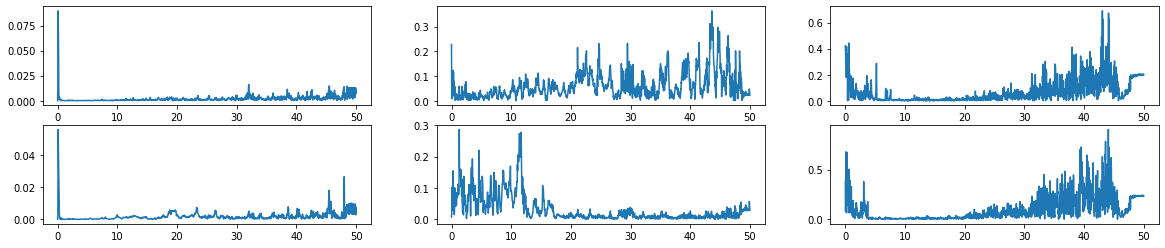

In [6]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Señales VT
D_train_s1 = min_max_scaler.fit_transform(SA_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(SA_train_1), np.max(SA_train_1)))      
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}'.format(np.min(D_train_s1), np.max(D_train_s1))) 
D_test_s1 = min_max_scaler.transform(SA_test_1)  

# Señales LP
D_train_s2 = min_max_scaler.fit_transform(SA_train_2)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(SA_train_2), np.max(SA_train_2)))      
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}'.format(np.min(D_train_s2), np.max(D_train_s2))) 
D_test_s2 = min_max_scaler.transform(SA_test_2)  

# Señales Tor
D_train_s3 = min_max_scaler.fit_transform(SA_train_3)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(SA_train_3), np.max(SA_train_3)))      
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}'.format(np.min(D_train_s3), np.max(D_train_s3))) 
D_test_s3 = min_max_scaler.transform(SA_test_3)  

# Graficando
plt.figure(3, figsize=(20, 4))
plt.subplot(231)
plt.plot(t2, D_train_s1[60])
plt.subplot(232)
plt.plot(t2, D_train_s2[18])
plt.subplot(233) 
plt.plot(t2, D_train_s3[38])
plt.subplot(234)
plt.plot(t2, D_test_s1[44])
plt.subplot(235)
plt.plot(t2, D_test_s2[34])
plt.subplot(236)
plt.plot(t2, D_test_s3[4])

# **2. Modelo AutoEncoder (TensorFlow / Keras)**

Importamos TensorFlow 2 que incluye Keras

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
print('version de TensorFlow:' + tf.__version__)

version de TensorFlow:2.8.2


**2.1 Configuración de la arquitectura del Autoencoder**

Configuramos la arquitectura del modelo de Autoencoder. Esta configuración será reallizada teneindo en cuenta el set de entrenamiento para el conjunto de señales VT.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Sequential
from keras.regularizers import l2 # cuando hay sobreajuste la regularización ayuda
# a decartar valores altos en la función de costo. Se puede colocar en cualquier capa
from keras.layers import Dropout  #apagar aleatoriamente algunas neuronas, 
# ayudando a eliminar el sobreajuste
from keras.callbacks import EarlyStopping
np.random.seed(23)

dim_entrada = D_train_s1.shape[1]      
entrada = Input(shape=(dim_entrada,))
print(D_train_s1.shape[1])             

# Encoder
x = Dense(800, activation='relu', kernel_regularizer=l2(0.005))(entrada)
x = Dropout(0.25)(x)
x = Dense(500, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.25)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.25)(x)
encoded = Dense(50, activation='relu', name='bottleneck_layer')(x)

# Decoder 
x = Dense(200, activation='relu')(encoded)
x = Dropout(0.25)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(800, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.25)(x)
decoded = Dense(1500, activation='sigmoid')(x)

# autoencoder = entrada + decoder (que contiene el encoder)
autoencoder = Model(inputs=entrada, outputs=decoded)

autoencoder.summary()

1500
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1500)]            0         
                                                                 
 dense (Dense)               (None, 800)               1200800   
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               400500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               100200    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0

**2.2 Optimización y Entrenamiento**

La pérdida corresponderá al error absoluto medio(Mean Absolute Error, MAE.                                                    
El optimizador será adam.                                              
Debido a que el set de datos (entrenamiento y validación) mayor corresponde a las señales sísmicas VT, el autoencoder es entrenado con este set de datos, teniendo en cuenta el desbalance que hay con los demás sets.

In [9]:
autoencoder.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
historia = autoencoder.fit(D_train_s1, D_train_s1,    
                           epochs=25,
                           batch_size=150,
                           validation_data=(D_test_s1, D_test_s1),    
                           shuffle=True)

Epoch 1/25
10/10 [==============================] - 4s 31ms/step - loss: 9.5929 - accuracy: 0.0000e+00 - val_loss: 7.0678 - val_accuracy: 0.0000e+00
Epoch 2/25
10/10 [==============================] - 0s 10ms/step - loss: 5.4475 - accuracy: 0.0000e+00 - val_loss: 3.6054 - val_accuracy: 0.0000e+00
Epoch 3/25
10/10 [==============================] - 0s 10ms/step - loss: 2.7548 - accuracy: 0.0027 - val_loss: 1.8635 - val_accuracy: 0.0000e+00
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 1.3816 - accuracy: 0.0374 - val_loss: 0.8976 - val_accuracy: 0.0000e+00
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.6499 - accuracy: 0.0781 - val_loss: 0.4119 - val_accuracy: 0.0000e+00
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2930 - accuracy: 0.0394 - val_loss: 0.1845 - val_accuracy: 0.0000e+00
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.1087 - val_loss: 0.0847 - val_ac

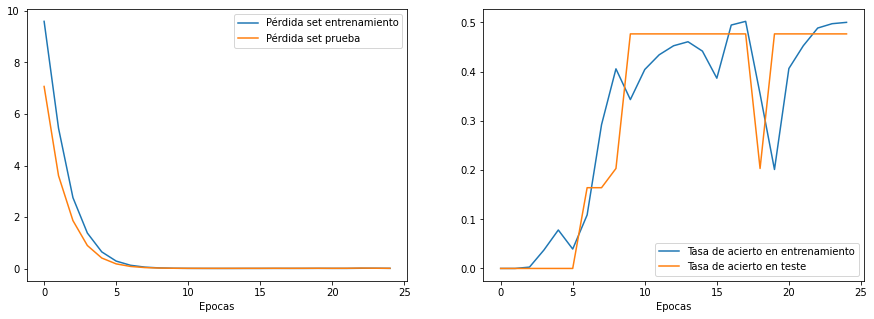

In [10]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Tasa de acierto en entrenamiento")
plt.plot(historia.history["val_accuracy"], label="Tasa de acierto en teste")
plt.xlabel('Epocas')
plt.legend()

# **3. Clasificación**

Identificamos qué tan bien el modelo es capaz de reconstruir las señales para las cuales fue entrenado (VT) como también las otras señales de tal forma que se pueda identificar el error de reconstrucción.

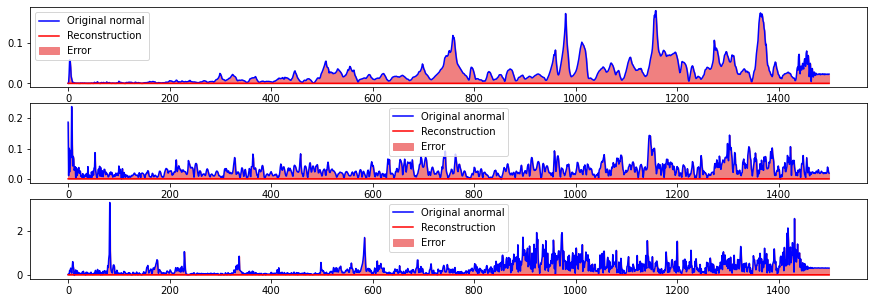

In [11]:
rec_1 = autoencoder(D_test_s1).numpy()
rec_2 = autoencoder(D_test_s2).numpy()
rec_3 = autoencoder(D_test_s3).numpy()

dato = 2    # Elegimos un dato al azar de los registro de los data sets de validación
# El data set con el menor número de datos de validación es para la señal Tor con 6 ejemplos.

plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.plot(D_test_s1[dato],'b')
plt.plot(rec_1[dato],'r')
plt.fill_between(np.arange(1500), rec_1[dato], D_test_s1[dato], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])
plt.subplot(3,1,2)
plt.plot(D_test_s2[dato],'b')
plt.plot(rec_2[dato],'r')
plt.fill_between(np.arange(1500), rec_2[dato], D_test_s2[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])
plt.subplot(3,1,3)
plt.plot(D_test_s3[dato],'b')
plt.plot(rec_3[dato],'r')
plt.fill_between(np.arange(1500), rec_3[dato], D_test_s3[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

**3.1 Identificación de la distribución del error**

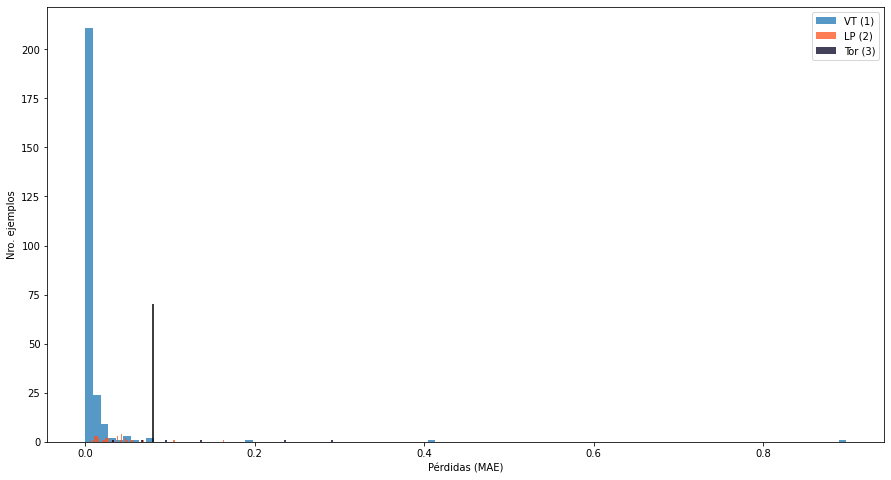

In [12]:
rec_1 = autoencoder.predict(D_test_s1)
rec_2 = autoencoder.predict(D_test_s2)
rec_3 = autoencoder.predict(D_test_s3)

loss_1 = tf.keras.losses.mae(rec_1, D_test_s1)
loss_2 = tf.keras.losses.mae(rec_2, D_test_s2)
loss_3 = tf.keras.losses.mae(rec_3, D_test_s3)

plt.figure(figsize=(15,8))
plt.hist(loss_1[None,:], bins=100, alpha=0.75, label='VT (1)')
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='LP (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='Tor (3)')

plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')

**3.2 Definición del humbral de clasificación**

In [13]:
umbral = np.mean(loss_1) + np.std(loss_1)
print("Umbral: ", umbral)

Umbral:  0.07492664389596075


**3.3 Sensitividad y Especificidad**

*   **Verdaderos positivos (TP):** anormales que han sido correctamente clasificados como anormales
*   **Falsos negativos (FN):** anormales que han sido clasificados erróneamente como normales
*   **Verdaderos negativos (TN):** normales que han sido correctamente clasificados como normales
*   **Falsos positivos (FP):** normales que han sido clasificados erróneamente como anormales

La **sensitividad** mide la proporción de anormales que fueron detectados correctamente como anormales. Una sensitividad del 100% detectará a todos los pacientes enfermos:

$$Sensitividad = \dfrac{TP}{TP+FN}$$

La **especificidad** mide la proporción de normales que fueron detectados correctamente como normales. Una especificidad del 100% detectará a todos los pacientes sanos:
$$Especificidad = \dfrac{TN}{TN+FP}$$

In [14]:
# Definiendo funciones para la clasificación individual
def identificar(modelo, datos, umbral):
  reconstrucciones = modelo(datos)
  perdida = tf.keras.losses.mae(reconstrucciones, datos)
  return tf.math.less(perdida, umbral)

def calcular_sensitividad(identificacion, titulo):
  TP = np.count_nonzero(~identificacion)
  FN = np.count_nonzero(identificacion)
  sen = 100*(TP/(TP+FN))

  print(titulo + ': {:.1f}%'.format(sen))

def calcular_especificidad(identificacion, titulo):
  TN = np.count_nonzero(identificacion)
  FP = np.count_nonzero(~identificacion)
  esp = 100*(TN/(TN+FP))

  print(titulo + ': {:.1f}%'.format(esp))
  return esp

In [15]:
# Identificación del tipo de señal
pred_1 = identificar(autoencoder, D_test_s1, umbral)
pred_2 = identificar(autoencoder, D_test_s2, umbral)
pred_3 = identificar(autoencoder, D_test_s3, umbral)

# Calculo de Especificidad
esp_1 = calcular_especificidad(pred_1,'Especificidad (cat. VT, VT)')

# Cálculo de Sensitividad
sen_2 = calcular_sensitividad(pred_2,'Sensitividad (cat. LP, NO VTs)')
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. Tor, NO VTs)')

Especificidad (cat. VT, VT): 98.8%
Sensitividad (cat. LP, NO VTs): 7.5%
Sensitividad (cat. Tor, NO VTs): 66.7%


**3.3 Clasificador II para las señales restantes: LP y Tor**

Usamos una configuración difernte de AutoEncoder a la anterior por una menos compleja debido a la cantidad de ejemplos disponibles en el data set de entrenamiento, para este caso corresponde a la señal LP, que es el segundo set en cantidad.

In [16]:
# Encoder
x = Dense(800, activation='relu', kernel_regularizer=l2(0.005))(entrada)
x = Dropout(0.25)(x)
x = Dense(250, activation='relu')(x)
x = Dropout(0.25)(x)
encoded = Dense(50, activation='relu', name='bottleneck_layer')(x)

# Decoder 
x = Dense(250, activation='relu')(encoded)
x = Dropout(0.25)(x)
x = Dense(800, activation='relu')(x)
x = Dropout(0.25)(x)
decoded = Dense(1500, activation='sigmoid')(x)

autoencoder2 = Model(inputs=entrada, outputs=decoded)

autoencoder2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1500)]            0         
                                                                 
 dense_7 (Dense)             (None, 800)               1200800   
                                                                 
 dropout_6 (Dropout)         (None, 800)               0         
                                                                 
 dense_8 (Dense)             (None, 250)               200250    
                                                                 
 dropout_7 (Dropout)         (None, 250)               0         
                                                                 
 bottleneck_layer (Dense)    (None, 50)                12550     
                                                                 
 dense_9 (Dense)             (None, 250)               1275

Optimización y entrenamiento

In [17]:
autoencoder2.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
historia = autoencoder2.fit(D_train_s2, D_train_s2,    
                           epochs=15,
                           batch_size=30,
                           validation_data=(D_test_s2, D_test_s2),    
                           shuffle=True)

Epoch 1/15
13/13 [==============================] - 1s 21ms/step - loss: 4.1445 - accuracy: 0.0000e+00 - val_loss: 2.3035 - val_accuracy: 0.0000e+00
Epoch 2/15
13/13 [==============================] - 0s 6ms/step - loss: 1.6025 - accuracy: 0.3536 - val_loss: 0.8321 - val_accuracy: 0.4750
Epoch 3/15
13/13 [==============================] - 0s 7ms/step - loss: 0.5585 - accuracy: 0.4282 - val_loss: 0.2552 - val_accuracy: 0.4750
Epoch 4/15
13/13 [==============================] - 0s 6ms/step - loss: 0.1816 - accuracy: 0.4282 - val_loss: 0.0858 - val_accuracy: 0.4750
Epoch 5/15
13/13 [==============================] - 0s 6ms/step - loss: 0.0851 - accuracy: 0.4282 - val_loss: 0.0446 - val_accuracy: 0.4750
Epoch 6/15
13/13 [==============================] - 0s 6ms/step - loss: 0.0695 - accuracy: 0.4282 - val_loss: 0.0384 - val_accuracy: 0.4750
Epoch 7/15
13/13 [==============================] - 0s 6ms/step - loss: 0.0643 - accuracy: 0.4254 - val_loss: 0.0477 - val_accuracy: 0.4750
Epoch 8/15


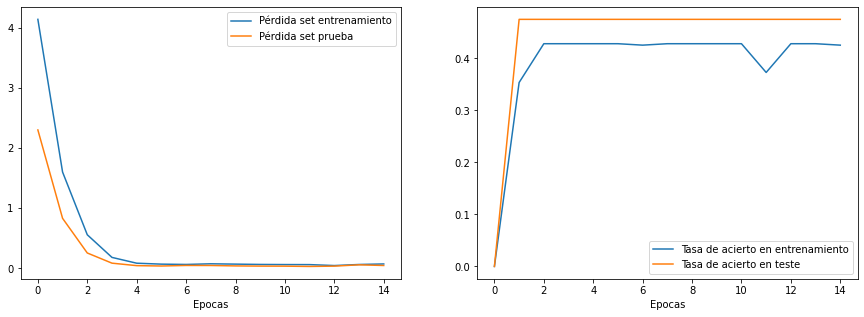

In [18]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Tasa de acierto en entrenamiento")
plt.plot(historia.history["val_accuracy"], label="Tasa de acierto en teste")
plt.xlabel('Epocas')
plt.legend()

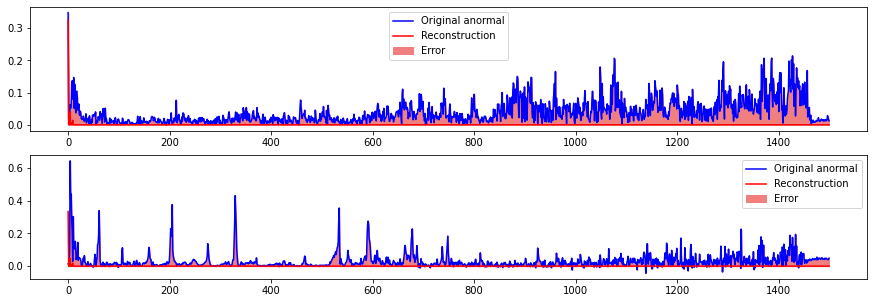

In [19]:
rec_2 = autoencoder2(D_test_s2).numpy()
rec_3 = autoencoder2(D_test_s3).numpy()

dato = 5    # Elegimos un dato al azar de los registro de los data sets de validación
# El data set con el menor número de datos de validación es para la señal Tor con 6 ejemplos.

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(D_test_s2[dato],'b')
plt.plot(rec_2[dato],'r')
plt.fill_between(np.arange(1500), rec_2[dato], D_test_s2[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])
plt.subplot(2,1,2)
plt.plot(D_test_s3[dato],'b')
plt.plot(rec_3[dato],'r')
plt.fill_between(np.arange(1500), rec_3[dato], D_test_s3[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

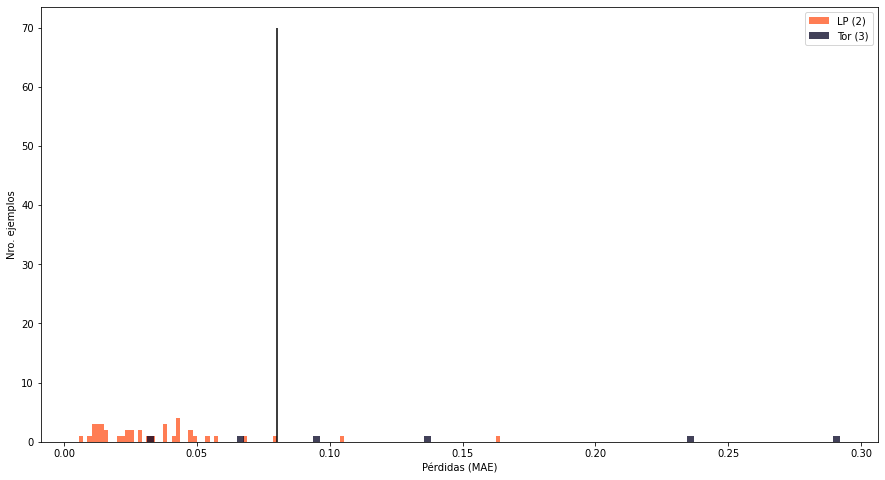

In [20]:
rec_2 = autoencoder.predict(D_test_s2)
rec_3 = autoencoder.predict(D_test_s3)

loss_2 = tf.keras.losses.mae(rec_2, D_test_s2)
loss_3 = tf.keras.losses.mae(rec_3, D_test_s3)

plt.figure(figsize=(15,8))
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='LP (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='Tor (3)')

plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')

In [21]:
umbral = np.mean(loss_2) + np.std(loss_2)
print("Umbral: ", umbral)

Umbral:  0.06466685269971882


In [22]:
# Identificación del tipo de señal
pred_2 = identificar(autoencoder, D_test_s2, umbral)
pred_3 = identificar(autoencoder, D_test_s3, umbral)

# Calculo de Especificidad
esp_2 = calcular_especificidad(pred_2,'Especificidad (cat. LP, LP)')

# Cálculo de Sensitividad
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. Tor, NO LPs)')

Especificidad (cat. LP, LP): 90.0%
Sensitividad (cat. Tor, NO LPs): 83.3%
